<a href="https://githubtocolab.com/DanielSanma/ProyectoIntroIA/blob/03-Modelos-e-iteraciones-Electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')

**1. Lectura de los dataset**

In [3]:
#Instalar kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [6]:
#Cargar los datos
!kaggle competitions download -c edsa-individual-electricity-shortfall-challenge

  0% 0.00/986k [00:00<?, ?B/s]
100% 986k/986k [00:00<00:00, 110MB/s]


In [7]:
#Descomprimir el archivo zip que contiene los archivos csv
!unzip \*.zip && rm *.zip

Archive:  edsa-individual-electricity-shortfall-challenge.zip
  inflating: df_test.csv             
  inflating: df_train.csv            
  inflating: sample_submission_load_shortfall (1).csv  


In [8]:
df = pd.read_csv('df_train.csv')
df

,Unnamed: 0,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
0,0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.000000,1.000000,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
1,1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.000000,1.000000,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2,2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.000000,1.000000,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
3,3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.000000,1.000000,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
4,4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.000000,0.333333,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,8758,2017-12-31 09:00:00,1.000000,level_6,0.0,2.666667,89.000000,95.666667,56.666667,4.333333,...,280.816667,281.276667,285.150000,287.573333,280.483333,290.150000,284.816667,279.686667,278.483333,-28.333333
8759,8759,2017-12-31 12:00:00,5.000000,level_6,0.0,2.000000,82.000000,85.000000,26.666667,8.000000,...,283.483333,287.483333,286.483333,288.616667,287.150000,291.150000,287.150000,282.400000,280.150000,2266.666667
8760,8760,2017-12-31 15:00:00,6.333333,level_9,0.4,7.333333,67.666667,71.000000,63.333333,8.333333,...,285.150000,289.816667,283.816667,285.330000,289.150000,286.816667,289.150000,283.956667,281.150000,822.000000
8761,8761,2017-12-31 18:00:00,7.333333,level_8,0.2,7.333333,67.666667,79.000000,63.333333,2.666667,...,283.483333,287.523333,278.816667,281.410000,286.816667,284.150000,289.150000,282.666667,280.816667,-760.000000


In [26]:
df.head()

,Unnamed: 0,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
0,0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
1,1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2,2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
3,3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
4,4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667


**4. Tratamiento de datos**

**4.1. Remoción de las lecturas cero de la variable objetivo**

In [27]:
for i in df.columns:
  print("%20s"%i, np.sum(df[i].isna()))

          Unnamed: 0 0
                time 0
   Madrid_wind_speed 0
   Valencia_wind_deg 0
      Bilbao_rain_1h 0
 Valencia_wind_speed 0
    Seville_humidity 0
     Madrid_humidity 0
   Bilbao_clouds_all 0
   Bilbao_wind_speed 0
  Seville_clouds_all 0
     Bilbao_wind_deg 0
Barcelona_wind_speed 0
  Barcelona_wind_deg 0
   Madrid_clouds_all 0
  Seville_wind_speed 0
   Barcelona_rain_1h 0
    Seville_pressure 0
     Seville_rain_1h 0
      Bilbao_snow_3h 0
  Barcelona_pressure 0
     Seville_rain_3h 0
      Madrid_rain_1h 0
   Barcelona_rain_3h 0
    Valencia_snow_3h 0
   Madrid_weather_id 0
Barcelona_weather_id 0
     Bilbao_pressure 0
  Seville_weather_id 0
   Valencia_pressure 2068
    Seville_temp_max 0
     Madrid_pressure 0
   Valencia_temp_max 0
       Valencia_temp 0
   Bilbao_weather_id 0
        Seville_temp 0
   Valencia_humidity 0
   Valencia_temp_min 0
  Barcelona_temp_max 0
     Madrid_temp_max 0
      Barcelona_temp 0
     Bilbao_temp_min 0
         Bilbao_temp 0
  Barcel

**4.2. Eliminación de las columnas con muchos datos faltantes**

Del análisi exploratorio de las variables encontramos que la unica variable con datos faltantes es Valencia_pressure, por lo que procederemos a eliminarla.

In [28]:
del(df["Valencia_pressure"])

**4.3. Transformación de las variables categoricas**

Las variables categoricas, como lo son en este caso "Valencia_wind_deg" y "Seville_pressure" pueden ser utiles a la hora de realizar el análisis, sin embargo, no pueden usadas en la forma categorica, por lo que se deben convertir en variables numericas que si podamos utilzar para entrenar un modelo.

In [29]:
var_categoricas = ['Valencia_wind_deg', 'Seville_pressure']
encoder = preprocessing.LabelEncoder()

for i in var_categoricas:
    
    df[i] = encoder.fit_transform(df[i])
    
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            8763 non-null   int64  
 1   time                  8763 non-null   object 
 2   Madrid_wind_speed     8763 non-null   float64
 3   Valencia_wind_deg     8763 non-null   int64  
 4   Bilbao_rain_1h        8763 non-null   float64
 5   Valencia_wind_speed   8763 non-null   float64
 6   Seville_humidity      8763 non-null   float64
 7   Madrid_humidity       8763 non-null   float64
 8   Bilbao_clouds_all     8763 non-null   float64
 9   Bilbao_wind_speed     8763 non-null   float64
 10  Seville_clouds_all    8763 non-null   float64
 11  Bilbao_wind_deg       8763 non-null   float64
 12  Barcelona_wind_speed  8763 non-null   float64
 13  Barcelona_wind_deg    8763 non-null   float64
 14  Madrid_clouds_all     8763 non-null   float64
 15  Seville_wind_speed   

In [30]:
dfi = df.set_index('time')
dfi

,Unnamed: 0,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0,0.666667,5,0.0,0.666667,74.333333,64.000000,0.000000,1.000000,0.000000,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
2015-01-01 06:00:00,1,0.333333,1,0.0,1.666667,78.333333,64.666667,0.000000,1.000000,0.000000,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2015-01-01 09:00:00,2,1.000000,9,0.0,1.000000,71.333333,64.333333,0.000000,1.000000,0.000000,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
2015-01-01 12:00:00,3,1.000000,8,0.0,1.000000,65.333333,56.333333,0.000000,1.000000,0.000000,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
2015-01-01 15:00:00,4,1.000000,7,0.0,1.000000,59.000000,57.000000,2.000000,0.333333,0.000000,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 09:00:00,8758,1.000000,6,0.0,2.666667,89.000000,95.666667,56.666667,4.333333,80.000000,...,280.816667,281.276667,285.150000,287.573333,280.483333,290.150000,284.816667,279.686667,278.483333,-28.333333
2017-12-31 12:00:00,8759,5.000000,6,0.0,2.000000,82.000000,85.000000,26.666667,8.000000,75.000000,...,283.483333,287.483333,286.483333,288.616667,287.150000,291.150000,287.150000,282.400000,280.150000,2266.666667
2017-12-31 15:00:00,8760,6.333333,9,0.4,7.333333,67.666667,71.000000,63.333333,8.333333,33.333333,...,285.150000,289.816667,283.816667,285.330000,289.150000,286.816667,289.150000,283.956667,281.150000,822.000000


In [31]:
copia_dfi = dfi.copy()
copia_dfi

,Unnamed: 0,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0,0.666667,5,0.0,0.666667,74.333333,64.000000,0.000000,1.000000,0.000000,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
2015-01-01 06:00:00,1,0.333333,1,0.0,1.666667,78.333333,64.666667,0.000000,1.000000,0.000000,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2015-01-01 09:00:00,2,1.000000,9,0.0,1.000000,71.333333,64.333333,0.000000,1.000000,0.000000,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
2015-01-01 12:00:00,3,1.000000,8,0.0,1.000000,65.333333,56.333333,0.000000,1.000000,0.000000,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
2015-01-01 15:00:00,4,1.000000,7,0.0,1.000000,59.000000,57.000000,2.000000,0.333333,0.000000,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 09:00:00,8758,1.000000,6,0.0,2.666667,89.000000,95.666667,56.666667,4.333333,80.000000,...,280.816667,281.276667,285.150000,287.573333,280.483333,290.150000,284.816667,279.686667,278.483333,-28.333333
2017-12-31 12:00:00,8759,5.000000,6,0.0,2.000000,82.000000,85.000000,26.666667,8.000000,75.000000,...,283.483333,287.483333,286.483333,288.616667,287.150000,291.150000,287.150000,282.400000,280.150000,2266.666667
2017-12-31 15:00:00,8760,6.333333,9,0.4,7.333333,67.666667,71.000000,63.333333,8.333333,33.333333,...,285.150000,289.816667,283.816667,285.330000,289.150000,286.816667,289.150000,283.956667,281.150000,822.000000


**5. Métodos Supervisados**

**5.1. Selección de Modelos**

In [32]:
#Función para reportar el error del modelo
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [33]:
#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):
    
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [34]:
X = dfi.drop(['load_shortfall_3h'],axis = 1)
y = dfi['load_shortfall_3h'].values

In [35]:
#--------Partición de los datos------------

from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(8763, 46) (8763,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(6134, 46) (2629, 46)


In [36]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [37]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  4803.64667 (± 40.82575209 )
RMSLE Train:  4759.62979 (± 30.29317159 )
---------
RMSLE Test:  4761.83359 (± 58.10567674 )
RMSLE Train:  4516.48133 (± 87.81361533 )
---------
RMSLE Test:  4705.94762 (± 71.68255348 )
RMSLE Train:  4453.44296 (± 50.00868987 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


**Comentarios:**

El modelo que dió mejor rendimiento fué el RandomForestRegressor.


In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [40]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 15}


**Implementación del mejor RandomForest**

In [41]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=9, n_estimators=5)

In [42]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  3500.40692
RMSLE del Random Forest seleccionado:  4361.62755


**6. Métodos no supervisados**

**6.1. PCA**

In [43]:
dfi.head()

,Unnamed: 0,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0,0.666667,5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
2015-01-01 06:00:00,1,0.333333,1,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2015-01-01 09:00:00,2,1.000000,9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
2015-01-01 12:00:00,3,1.000000,8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
2015-01-01 15:00:00,4,1.000000,7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667


In [45]:
X = dfi.drop(['load_shortfall_3h'],axis = 1)
y = dfi['load_shortfall_3h'].values

In [46]:
X.head()

,Unnamed: 0,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0,0.666667,5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,...,281.013000,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000
2015-01-01 06:00:00,1,0.333333,1,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,...,280.561667,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667
2015-01-01 09:00:00,2,1.000000,9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,...,281.583667,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667
2015-01-01 12:00:00,3,1.000000,8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,...,283.434104,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219
2015-01-01 15:00:00,4,1.000000,7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,...,284.213167,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437


In [47]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(X)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Rdm_forest.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

(6134, 1) (2629, 1)
RMSLE del modelo con  1 elementos:  5080.26334
------------
(6134, 3) (2629, 3)
RMSLE del modelo con  3 elementos:  4046.81552
------------
(6134, 5) (2629, 5)
RMSLE del modelo con  5 elementos:  4016.13674
------------
(6134, 7) (2629, 7)
RMSLE del modelo con  7 elementos:  4110.51994
------------
(6134, 9) (2629, 9)
RMSLE del modelo con  9 elementos:  4277.17437
------------
Mejor RMSLE:  4016.13674   ; obtenido con  5  componentes para PCA


In [48]:
#MEJOR PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(6134, 5) (2629, 5)


In [49]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [50]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=10)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 10}


In [51]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

(6134, 5) (2629, 5)


RandomForestRegressor(max_depth=9, n_estimators=15)

In [52]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  3427.68741
RMSLE del Random Forest seleccionado:  3918.98953


**6.2. NMF**

Para aplicar este método debemos eliminar las variables que contengan valores negativos.

In [54]:
X2 = X.drop([],axis=1)

In [55]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=15)
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(X2)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

(6134, 1) (2629, 1)
RMSLE del modelo con  1 elementos:  5967.66546
------------
(6134, 3) (2629, 3)
RMSLE del modelo con  3 elementos:  4293.85153
------------
(6134, 5) (2629, 5)
RMSLE del modelo con  5 elementos:  5008.65362
------------
(6134, 7) (2629, 7)
RMSLE del modelo con  7 elementos:  5317.83723
------------
(6134, 9) (2629, 9)
RMSLE del modelo con  9 elementos:  5285.10819
------------
Mejor RMSLE:  4293.85153   ; obtenido con  3  componentes para PCA


In [56]:
#MEJOR NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(6134, 3) (2629, 3)


In [57]:
#Nota: esta celda requiere de gran tiempo para completarse
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [58]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=8)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 8}


In [59]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

(6134, 3) (2629, 3)


DecisionTreeRegressor(max_depth=15)

In [60]:
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  1786.90157
RMSLE del Decision Tree seleccionado:  3994.96956


**7. Curvas de aprendizaje**

Usamos el módulo learnin_curve de sk.leanr.model_selection, mediante el cual al brindarle información de los tamaños del dataset, el tipo de estimador y el método de hacer los split para la metodología de cross-validation

**7.1. Métodos supervisados**

In [62]:
X = dfi.drop(['load_shortfall_3h'],axis = 1)
y = dfi['load_shortfall_3h'].values
X = X.drop([],axis = 1)

In [63]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(8763, 46) (8763,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(6134, 46) (2629, 46)


**7.1.1. Decision Tree**

In [64]:
Des_tree1 = DecisionTreeRegressor(max_depth=15)
train_sizes, train_scores, valid_scores = learning_curve(Des_tree1, Xtv, ytv, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

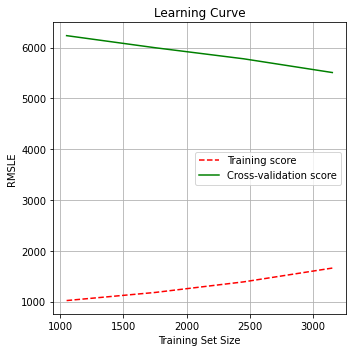

In [69]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [71]:
train_mean

array([1018.87212721, 1178.58776434, 1387.13952932, 1658.56780649])

In [72]:
valid_mean

array([6235.83961326, 5997.67059665, 5779.59619748, 5509.41227232])

In [73]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

**7.1.2. Random Forest**

In [74]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)

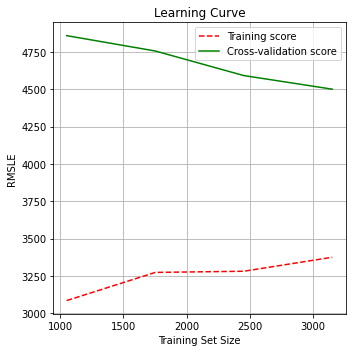

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [75]:
lc_plot(Rdm_forest,Xtv,ytv)

**7.2. Método no supervisado + Método supervisado**

**7.2.1. PCA + Random Forest**

In [76]:
X = dfi.drop(['load_shortfall_3h'],axis = 1)
y = dfi['load_shortfall_3h'].values

In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)

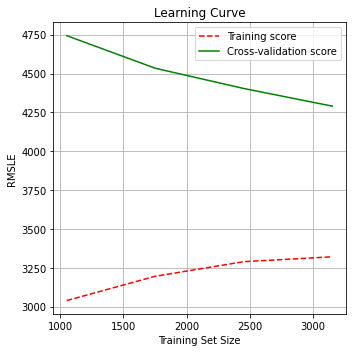

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [78]:
lc_plot(Rdm_forest,Xtv,ytv)

**7.2.2. NMF + Decision Tree**

In [79]:
X2 = X.drop([],axis=1)

In [80]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=15)

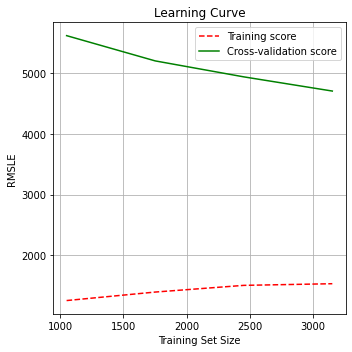

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [81]:
lc_plot(Des_tree,Xtv,ytv)

In [ ]:
submission = pd.DataFrame([df.time, pd.Series(Des_tree.predict(Xts), name="load_shortfall_3h")]).T
submission.head()

In [ ]:
submission.to_csv("Electricity_kaggle.csv", index=False)

In [ ]:
!head Electricity_kaggle.csv

In [ ]:
!wc Electricity_kaggle.csv